# Saltmarsh Vegetation Maps

#### Create the intial marsh condition maps

In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib.colors import ListedColormap
from typing import Dict, List
import numpy as np

In [2]:
# Import functions from util
from util import add_missing_cats
from util import create_categorical_cmap

In [3]:
# data paths
RAW_DATA = "../data/raw/"
CLEAN_DATA = "../data/clean/"
NWI_DATA = CLEAN_DATA + "nwi/"
OUTPUT = "../output/"

In [4]:
# read in the SLAMM conversion key
slamm_key = gpd.read_file(RAW_DATA + 'slamm_cats.csv')
slamm_key.rename(columns = {'SLAMM Number': "SLAMMCODE"}, inplace=True)
slamm_key['SLAMMCODE'] = slamm_key['SLAMMCODE'].astype(float)

In [5]:
# Create a new group that simplifies the SLAMM categories of transition and saltmarsh into one category
slamm_key['map_category']  = ['Saltmarh Habitat' if a == 'Transitional Marsh' or a == 'Saltmarsh'
                              else a 
                              for a in slamm_key['Aggregation Category']]

In [6]:
# Colors and order for legend
habitat_colors = {
    'Open Water': '#5A8093FF',
    'Low Tidal': '#9FBAD3FF', 
    'Saltmarh Habitat': '#97AD3DFF', 
    'Freshwater Tidal':  '#415521FF', 
    'Freshwater Non-Tidal': '#7F6552FF'
}
# set order of legend
order_leg = [
    'Open Water',
    'Low Tidal', 
    'Saltmarh Habitat', 
    'Freshwater Tidal', 
    'Freshwater Non-Tidal'
]

In [7]:
# Function to make saltmarsh vegetation maps
def make_veg_map(slamm_file_path:str, leg_names:pd.DataFrame, color_dict, order_leg, output_path:str):

    # read in file
    slamm_file = gpd.read_file(slamm_file_path)
    slamm_file = pd.merge(slamm_file, leg_names, on='SLAMMCODE', how='left')
    slamm_file.rename(columns = {'geometry_x': "geometry"}, inplace=True)
    slamm_file[['SLAMMCODE', 'Category Name', 'Aggregation Category', 'map_category', 'geometry']]

    # add missing categories
    missing_keys = set(order_leg) - set(slamm_file['map_category'].unique())
    extra_df = pd.DataFrame([
        {
            'SLAMMCODE': 0,
            'Category Name': None,
            'Aggregation Category': None,
            'map_category': missing_key,
            'geometry': None
        }
    for missing_key in missing_keys])
    slamm_file = pd.concat([slamm_file, extra_df])
    
    # set x and y limits
    xlim = (slamm_file.total_bounds[0],  slamm_file.total_bounds[2])
    ylim = (slamm_file.total_bounds[1],  slamm_file.total_bounds[3])

    # Make map
    fig, ax = plt.subplots(figsize=(15, 10))
    slamm_file.plot(ax=ax, 
                column='map_category', 
                cmap = create_categorical_cmap(color_dict, order_leg),
                legend=True)
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs = slamm_file.crs, zoom=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])
    legend = ax.get_legend()
    handles = [None] * len(order_leg)
    for handle, label in zip(legend.legend_handles, legend.texts):
        text = label.get_text()
        handles[order_leg.index(text)] = handle
    ax.legend(handles, order_leg)
    ax

    # Save map
    fig.savefig(output_path, dpi=350, bbox_inches="tight")

    return slamm_file


C:\Users\AMarley.ERG\AppData\Local\Temp\ipykernel_41644\1894880619.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  slamm_file = pd.concat([slamm_file, extra_df])


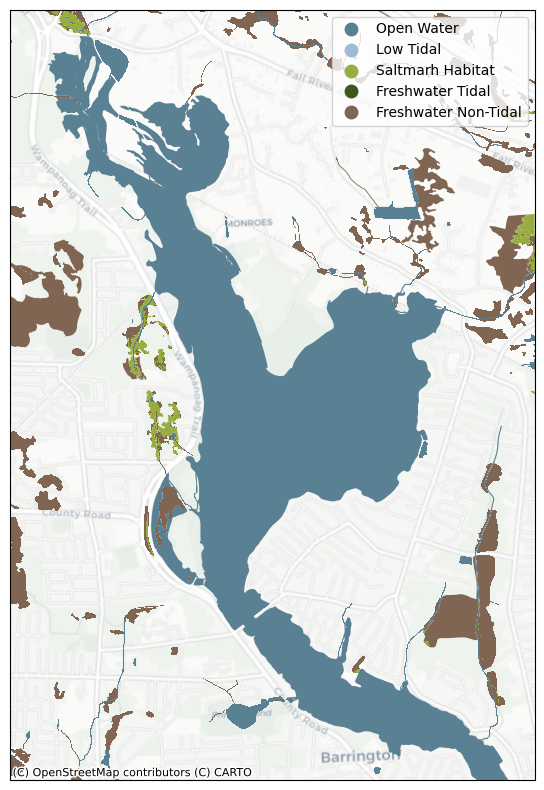

In [17]:
ri2_slamm = make_veg_map(
    CLEAN_DATA + 'slamm/ri2/veg/ri2_1slr_40_nm_veg.geojson',
    slamm_key,
    habitat_colors,
    order_leg,
    OUTPUT + 'ri2/ri2_1slr_40_nm_veg.png') 

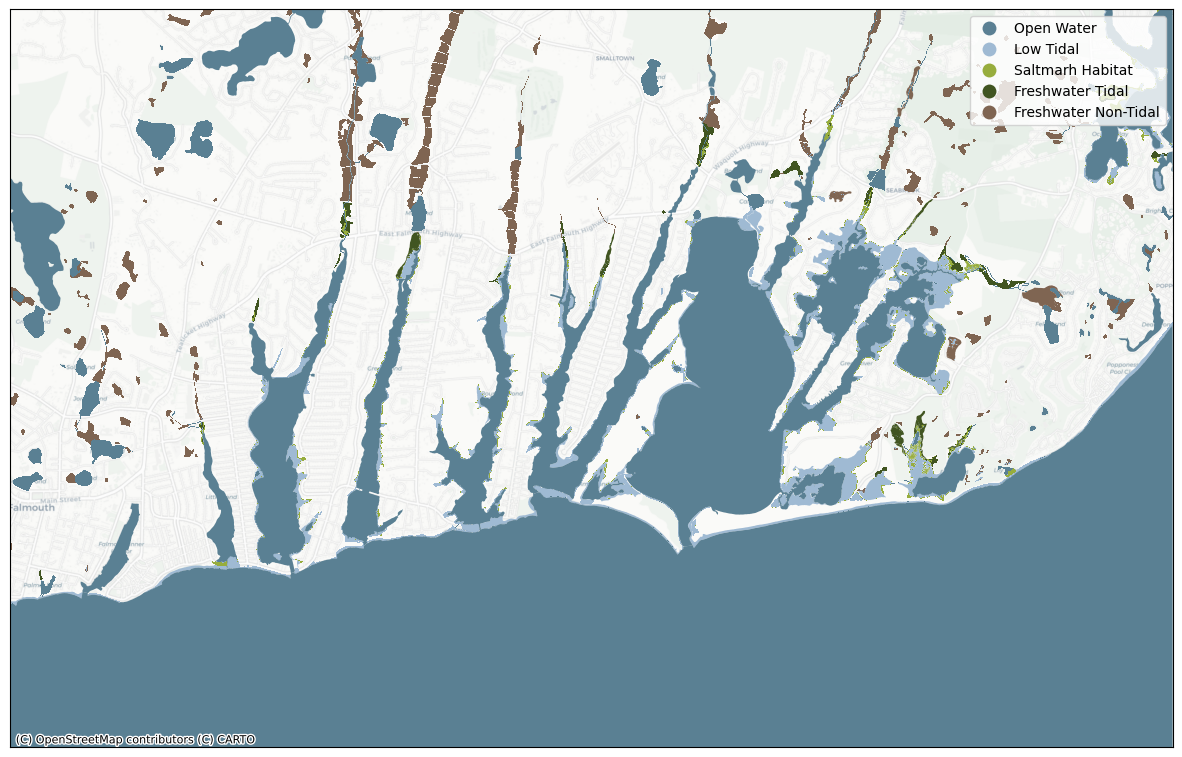

In [15]:
cc1_nwi_slamm = make_veg_map(
    CLEAN_DATA + 'slamm/cc1/veg/cc1_1slr_40_sm_veg.geojson',
    slamm_key,
    habitat_colors,
    order_leg,
    OUTPUT + 'cc1/cc1_veg_sm_1slr_40.png') 

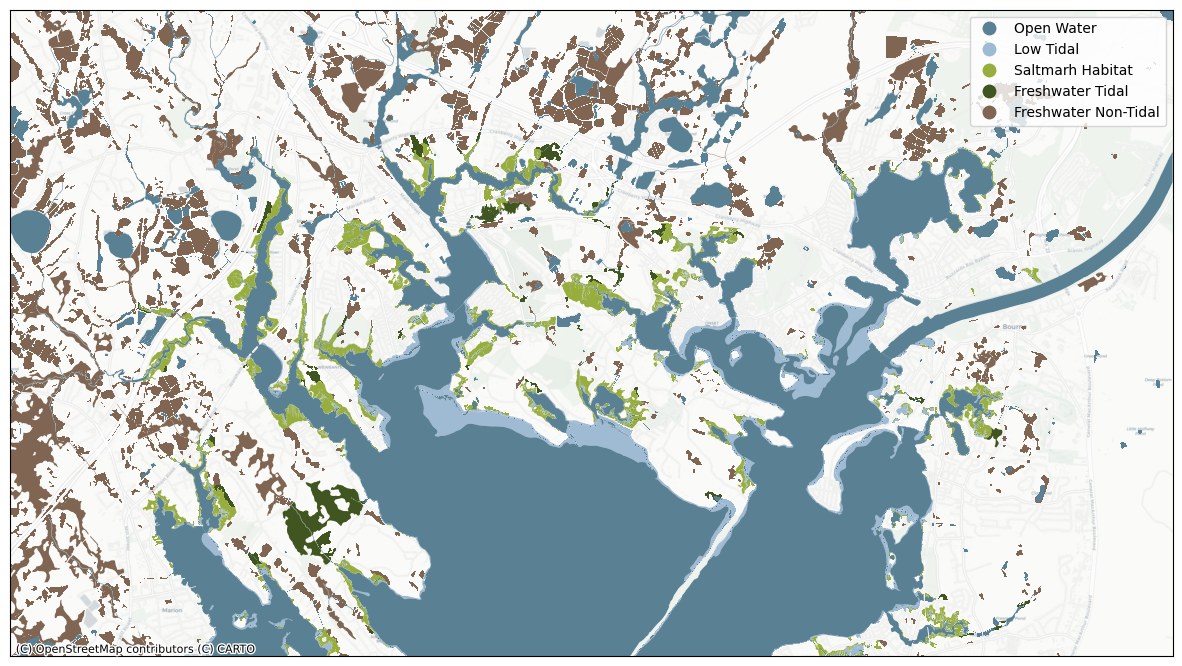

In [14]:
ma2_nwi_slamm = make_veg_map(
    CLEAN_DATA + 'slamm/ma2/veg/ma2_1slr_40_sm_veg.geojson',
    slamm_key,
    habitat_colors,
    order_leg,
    OUTPUT + 'ma2/ma2_veg_sm_1slr_40.png') 

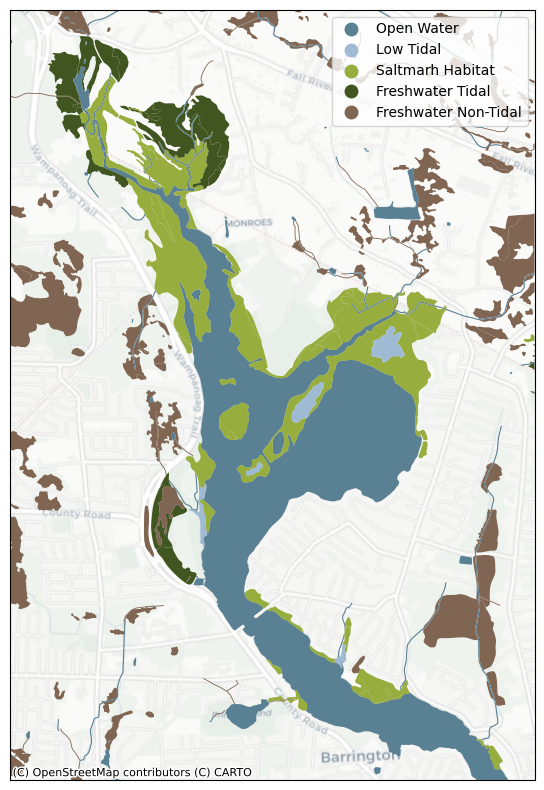

In [11]:
ri2_nwi_slamm = make_veg_map(
    NWI_DATA + "ri2_nwi.geojson",
    slamm_key,
    habitat_colors,
    order_leg,
    OUTPUT + 'ri2/ri2_veg_sm.png') 

In [4]:
# create function to get the area of each marsh
def get_marsh_area(nwi_slamm, which_marsh:str):
    nwi_slamm_filt = nwi_slamm[nwi_slamm['map_category'].isin(['Low Tidal', 'Saltmarh Habitat', 'Freshwater Tidal'])] 
    nwi_slamm_filt = nwi_slamm_filt[['map_category', 'geometry']]
    nwi_slamm_filt = nwi_slamm_filt.dissolve(by='map_category')
    nwi_slamm_filt['area_m2'] = nwi_slamm_filt.geometry.area
    nwi_slamm_filt['area_acres'] = nwi_slamm_filt['area_m2']/4047
    nwi_slamm_filt.drop('geometry', axis = 1, inplace=True)
    nwi_slamm_filt.to_csv(NWI_DATA + f'{which_marsh}_marsh_area.csv')
    return nwi_slamm_filt

In [16]:
cc1_marsh_area = get_marsh_area(cc1_nwi_slamm, 'cc1')
ma2_marsh_area = get_marsh_area(ma2_nwi_slamm, 'ma2')
ri2_marsh_area = get_marsh_area(ri2_nwi_slamm, 'ri2')